# Voyager-1 detection at ATA, 2020-11-14

In this notebook we analyze a series of IQ recordings of the Voyager-1 X-band signal done at Allen Telescope Array on 2020-11-14. For these recordings, the X and Y polarizations of dishes 1a and 4g were digitized at the RF converter board output by two USRP N32x. The recordings are 16 bit IQ at 960ksps and the telescope LO was tuned to 8419.7MHz to get the Voyager-1 signal approximately in the middle of the passband (taking the downlink Doppler into account).

The recordings consist of a series of four recordings of approximately 30 minutes each. Between each recording, there is a gap of a few minutes that was used to observe a phase calibrator for beamforming.

Beamforming processing is not included in this notebook yet.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from cycler import cycler
import dask.array as da
import dask.delayed
from scipy.constants import c
from astroquery.jplhorizons import Horizons
from astropy.time import Time, TimeDelta
from gnuradio.blocks import parse_file_metadata
import pmt
import scipy.signal

import pathlib
import os

plt.rcParams.update({'font.size': 14})
custom_cycler = (cycler(color = ['k', 'r', 'k', 'r']) +
                 cycler(linestyle = ['-', '-', ':', ':']))

In [2]:
fs = 0.96e6
lo_freq = 8419.7e6
spacecraft_freq = 8420.432097e6
path = pathlib.Path('/home/destevez/voyager1-2020-11-14/')
recordings = sorted(path.glob('Voyager-1_*_0x.sigmf-data'))
recordings

[PosixPath('/home/destevez/voyager1-2020-11-14/Voyager-1_2020-11-14T18:48:23.992418_0x.sigmf-data'),
 PosixPath('/home/destevez/voyager1-2020-11-14/Voyager-1_2020-11-14T19:27:10.955064_0x.sigmf-data'),
 PosixPath('/home/destevez/voyager1-2020-11-14/Voyager-1_2020-11-14T20:04:38.919535_0x.sigmf-data'),
 PosixPath('/home/destevez/voyager1-2020-11-14/Voyager-1_2020-11-14T20:41:11.651968_0x.sigmf-data')]

In [3]:
def read_meta(path):
    with open(str(path).replace('.sigmf-data', '.hdr'), 'rb') as f:
        header = f.read(parse_file_metadata.HEADER_LENGTH)
        header = pmt.deserialize_str(header)
        header = parse_file_metadata.parse_header(header, False)
        extra = f.read(header['extra_len'])
    extra = pmt.deserialize_str(extra)
    parse_file_metadata.parse_extra_dict(extra, header, False)
    return header

timestamps = Time([read_meta(r)['rx_time'] for r in recordings], format = 'unix')
durations = [r.stat().st_size/(4*fs) for r in recordings]
timestamps_ends = Time([t0 + TimeDelta(d, format = 'sec') for t0,d in zip(timestamps, durations)])

We fetch the ephemeris data from [Horizons](https://ssd.jpl.nasa.gov/horizons.cgi) using [astroquery](https://www.astropy.org/astroquery/). This is based on the code in [Nick Foster's Voyager-1 notebook](https://github.com/bistromath/voyager/blob/master/voyager.ipynb). We are mainly interested in the `delta_rate` data. The data is fetched with a step of roughly 8.6 seconds, and linear interpolation is used to get the Doppler between each pair of ephemerides. We are looking for mHz precision in our Doppler correction code, since we are interested in using sub-Hz FFT resolution.

In [4]:
observatory_code = -72 #set to -72 for HCRO, -9 for GBT
query = Horizons(id = 'Voyager 1', location = str(observatory_code),
                 epochs = {'start' : str(timestamps[0].datetime).split('.')[0],
                           'stop' : str(timestamps_ends[-1].datetime).split('.')[0],
                           'step' : f'1000'},
                 id_type = 'majorbody')
eph = query.ephemerides()
doppler = -eph['delta_rate']*1e3/c*lo_freq

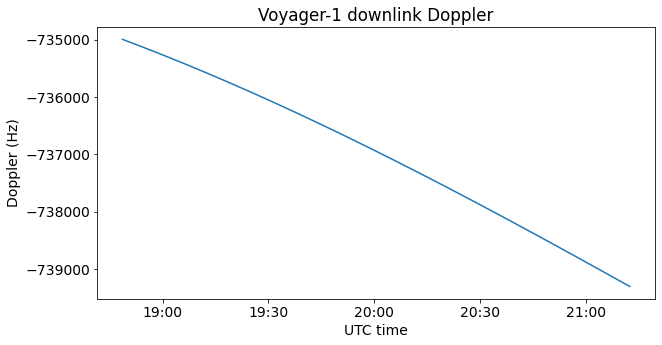

In [5]:
plt.figure(figsize = (10,5), facecolor = 'w')
plt.plot(Time(eph['datetime_jd'], format = 'jd').datetime, doppler)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Voyager-1 downlink Doppler')
plt.ylabel('Doppler (Hz)')
plt.xlabel('UTC time');

We already have corrected for some 730kHz of Doppler by not tuning to the Voyager-1 transmit frequency. The figure below shows the remaining Doppler that we need to correct in the baseband data.

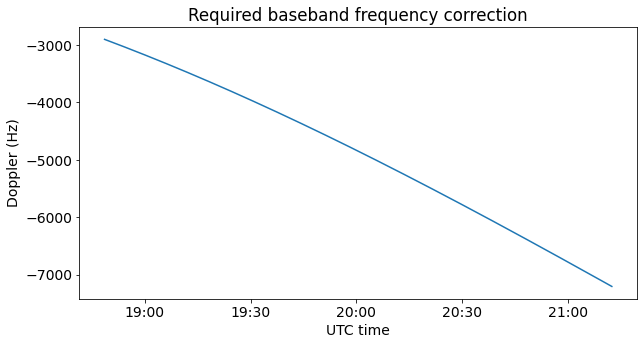

In [6]:
baseband_freq = doppler + spacecraft_freq - lo_freq
plt.figure(figsize = (10,5), facecolor = 'w')
plt.plot(Time(eph['datetime_jd'], format = 'jd').datetime, baseband_freq)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title('Required baseband frequency correction')
plt.ylabel('Doppler (Hz)')
plt.xlabel('UTC time');

We do a linear interpolation of the Doppler to a grid with 0.01 second spacing and then compute the carrier phase at each point of that grid.

In [7]:
t0 = Time(eph['datetime_jd'][0], format = 'jd')
t0.format = 'unix'
t1 = Time(eph['datetime_jd'][-1], format = 'jd')
t1.format = 'unix'
nsecs = int(np.ceil((t1-t0).sec))
tstep = 0.01
t_freq = t0 + np.arange(int(nsecs/tstep)) * TimeDelta(tstep,  format = 'sec')
bb_freq = np.interp(t_freq.jd, Time(eph['datetime_jd'], format = 'jd').jd, baseband_freq)
bb_phase = 2*np.pi*np.cumsum(bb_freq)*tstep

This is the core signal processing. It takes lots of CPU, RAM and some time to run.

The IQ file is loaded using dask for parallel processing, the DC offset is cancelled, each of the channels is normalized by dividing by its average power, the circular polarizations are sythesized by using the X-Y phase offsets calibrated in an observation of Tianwen-1 (RHCP X-band signal) done on the same day, and the Doppler is corrected using the phase versus time computed above. Finally, averaged spectra are produced for each of the dishes and polarizations. Each of the four recordings is processed separately.

In [8]:
Nfft = 2**21
fs = 0.96e6
chunksize = int(fs)

# Optionally use an FFT window
#w = np.blackman(Nfft)
w = 1

circular_pol = True

nchans = 4
spectra = np.zeros((len(recordings), nchans, Nfft))
pwr_t = list()

def load_chunks(path, chunksize, dtype):
    fsize = os.stat(path).st_size
    dtype = np.dtype(dtype)
    items = fsize // dtype.itemsize
    chunks = [da.from_delayed(
                dask.delayed(np.fromfile)(path, dtype = dtype, count = chunksize, offset = j * dtype.itemsize),
                shape = (min(chunksize, items - j),),
                dtype = dtype)
             for j in range(0, items, chunksize)]
    return da.concatenate(chunks)

for j,recording in enumerate(recordings):
    x = [load_chunks(str(recording).replace('_0x', chan),
                     chunksize = 2*chunksize, dtype = 'int16').reshape((-1,2))
            for chan in ('_0x','_0y','_1x','_1y')]
    l = np.min([a.shape[0] for a in x])
    x = da.array([a[:l] for a in x])
    x = x[:,:,0] + 1j*x[:,:,1]
    
    # remove DC offset
    dc_rem = Nfft * 0.25
    x = x[:,:x.shape[1]//dc_rem*dc_rem].reshape((x.shape[0],-1,dc_rem))
    x = (x - np.average(x, axis = 2)[...,np.newaxis]).reshape((x.shape[0], -1))
    
    # compute power vs time
    pwr_avg = int(fs * 10)
    pwr_t.append(np.average(np.abs(x[:, :x.shape[1]//pwr_avg*pwr_avg].reshape((x.shape[0],-1,pwr_avg)))**2,
                           axis = 2).compute())
    
    # circular polarization synthesis
    if circular_pol:
        # normalize power
        pwr = np.sqrt(np.average(np.abs(x)**2, axis = 1)).compute()
        x = x/pwr[:,np.newaxis]
        x = da.array([x[0] - np.exp(1j*np.deg2rad(154.42))*x[1], # LHCP 1a
                      x[2] - np.exp(1j*np.deg2rad(-131.25))*x[3], # LHCP 4g
                      x[0] + np.exp(1j*np.deg2rad(154.42))*x[1], # RHCP 1a
                      x[2] + np.exp(1j*np.deg2rad(-131.25))*x[3]]) # RHCP 4g
    
    t0 = read_meta(recording)['rx_time']
    t = t0 + da.arange(x.shape[1])/fs
    phi = t.map_blocks(lambda a: np.interp(a, t_freq.value, bb_phase), dtype = 'float')
    
    lo = np.exp(-1j*phi)
    
    y = (lo*x)[:,:x.shape[1]//Nfft*Nfft].reshape((x.shape[0],-1,Nfft))
    y = y * w
    spec = np.fft.fftshift(np.sum(np.abs(np.fft.fft(y))**2, axis = 1), axes = -1)
    spectra[j] = spec.compute(scheduler = 'threads', num_workers = 32)

To ensure the quality of the data, we plot the power versus time for each of the recorded channels (two polarizations per antenna). This allows us to see if there are any problems due to strong RFI, sudden noise figure increase, etc. Since each of the channels has a different power, the power of each channel is divided by the average power of that channel over all the recordings in other to centre them around the same normalized unity power. We see that there are only changes in power of a few percent. This means that the data is good.

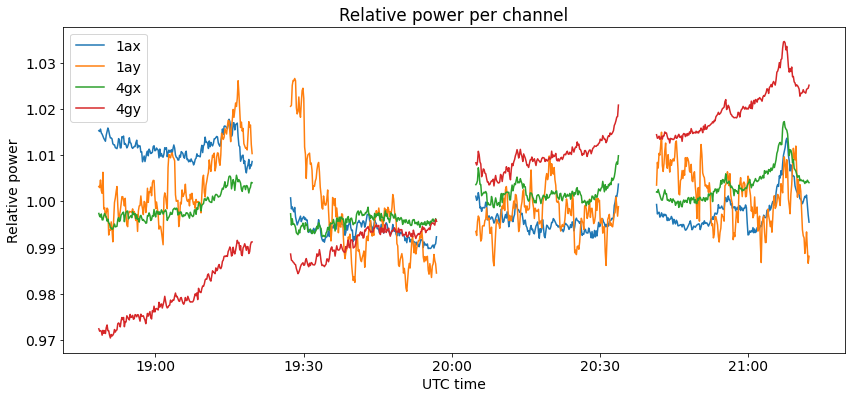

In [9]:
pwr_t_avg = np.sum([np.sum(p, axis = 1) for p in pwr_t], axis = 0)/np.sum([p.shape[1] for p in pwr_t])
plt.figure(figsize = (14,6), facecolor = 'w')
for j,p in enumerate(pwr_t):
    t0 = read_meta(recordings[j])['rx_time']
    t = t0 + np.arange(p.shape[1])*pwr_avg/fs
    t = Time(t, format = 'unix')
    plt.gca().set_prop_cycle(None)
    plt.plot(t.datetime, (p/pwr_t_avg.reshape((-1,1))).T)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xlabel('UTC time')
plt.ylabel('Relative power')
plt.legend(['1ax', '1ay', '4gx', '4gy'])
plt.title('Relative power per channel');

The bandpass for each antenna and polarization is calibrated by fitting a degree four polynomial to the average spectrum of that antenna and polarization over all the recordings. The steep passband edges are not considered for the polynomial fit. This polynomial describing the passband shape is then used to obtain a flat passband.

The carrier of Voyager-1 is already visible in the LHCP signals of both dishes.

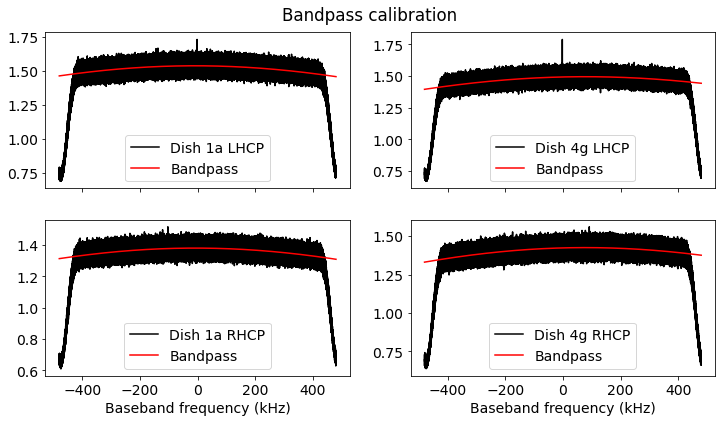

In [10]:
channel_labels = ['Dish 1a LHCP', 'Dish 4g LHCP', 'Dish 1a RHCP', 'Dish 4g RHCP']
spectra_cal = spectra.copy()
n_fit = 4
p_fit = np.empty((nchans, n_fit+1))
fig, ax = plt.subplots(2, 2, figsize = (12,6), sharex = True)
ax = ax.ravel()
for j in range(nchans):
    fit_sel = slice(3*Nfft//32, Nfft*29//32)
    spectra_sum = np.sum(spectra[:,j], axis = 0)
    p_fit[j] = np.polyfit(np.arange(Nfft)[fit_sel], spectra_sum[fit_sel], n_fit)
    spectra_cal[:,j] = spectra[:,j] / np.polyval(p_fit[j], np.arange(Nfft))
    ax[j].set_prop_cycle(custom_cycler)
    freqs = np.fft.fftshift(np.fft.fftfreq(Nfft,1/fs))
    ax[j].plot(freqs*1e-3, 1e-10*spectra_sum, label = channel_labels[j])
    ax[j].plot(freqs*1e-3, 1e-10*np.polyval(p_fit[j], np.arange(Nfft)),
              label = 'Bandpass')
    ax[j].legend(loc = 'lower center')
for j in range(2,4):
    ax[j].set_xlabel('Baseband frequency (kHz)')
plt.suptitle('Bandpass calibration')
plt.subplots_adjust(top=0.92);

After bandpass calibration we get a flat spectrum normalized to unity power spectral density.

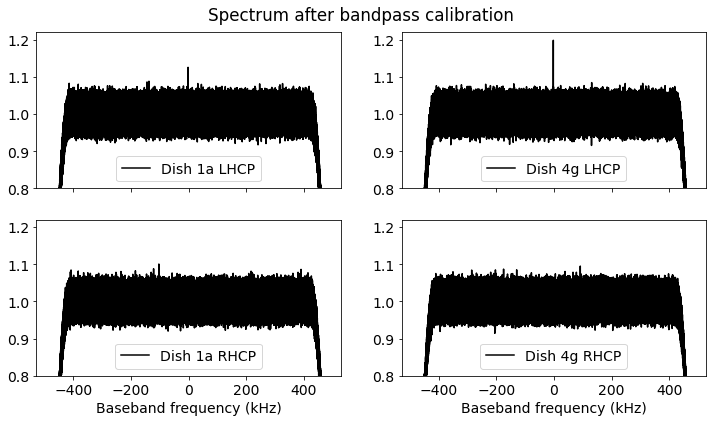

In [11]:
fig, ax = plt.subplots(2, 2, figsize = (12,6), sharex = True)
ax = ax.ravel()
for j in range(nchans):
    ax[j].set_prop_cycle(custom_cycler)
    freqs = np.fft.fftshift(np.fft.fftfreq(Nfft,1/fs))
    spectra_sum_cal = np.sum(spectra_cal[:,j], axis = 0)
    ax[j].plot(freqs*1e-3, spectra_sum_cal, label = channel_labels[j])
    ax[j].legend(loc = 'lower center')
    ax[j].set_ylim((0.8, 1.22))
for j in range(2,4):
    ax[j].set_xlabel('Baseband frequency (kHz)')
plt.suptitle('Spectrum after bandpass calibration')
plt.subplots_adjust(top=0.92);

We average the spectra of both dishes. The cells below show the standard deviation of the resulting spectrum (ignoring the steep skirts at the edges) and check that the average is very close to one. This is used to compute the significance level of the detection in sigmas.

In [12]:
spectra_total = np.sum(spectra_cal, axis = (0,1))/nchans

In [13]:
sigma = np.std(spectra_total[fit_sel])
sigma

0.00868639753957714

In [14]:
np.average(spectra_total[fit_sel])

0.9999999999630435

The figure below shows the detection in significance level units. This is the PSD normalized in such a way that the noise has zero mean and unity variance.

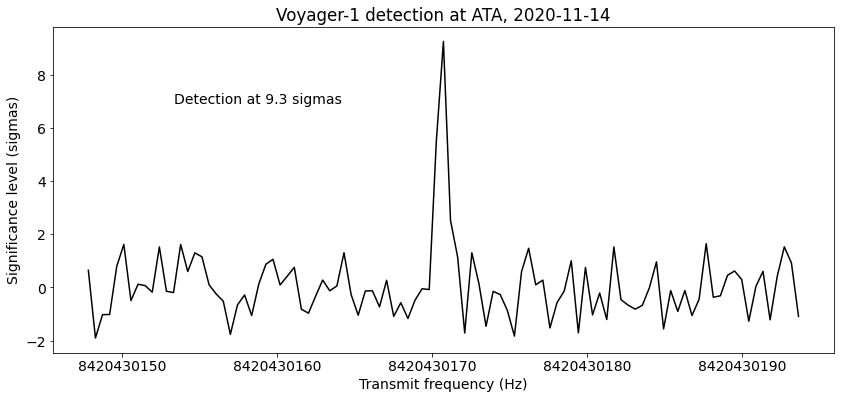

In [15]:
peak = np.argmax(spectra_total)
sel = range(peak-50,peak+51)
freqs = np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs))[sel] + spacecraft_freq
plt.figure(figsize = (14,6), facecolor = 'w')
plt.gca().set_prop_cycle(custom_cycler)
plt.gca().ticklabel_format(useOffset = False, style = 'plain')
significance = (spectra_total[sel] - 1)/sigma
plt.plot(freqs, significance)
sig = np.max(significance)
plt.text(freqs[freqs.size//8], sig*3/4, f'Detection at {sig:.1f} sigmas')
plt.title('Voyager-1 detection at ATA, 2020-11-14')
plt.xlabel('Transmit frequency (Hz)')
plt.ylabel('Significance level (sigmas)');

The cells bellow show the frequency where the peak was detected in the Doppler-corrected passband, and the corresponding transmit frequency at the spacecraft.

In [16]:
np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs))[peak]

-1926.26953125

In [17]:
spacecraft_freq + np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs))[peak]

8420430170.730469

The next figure shows the detection in each of the dishes and each of the recordings. We see that the signal in the first two recordings is stronger, while it fades in the noise for the second two recordings.

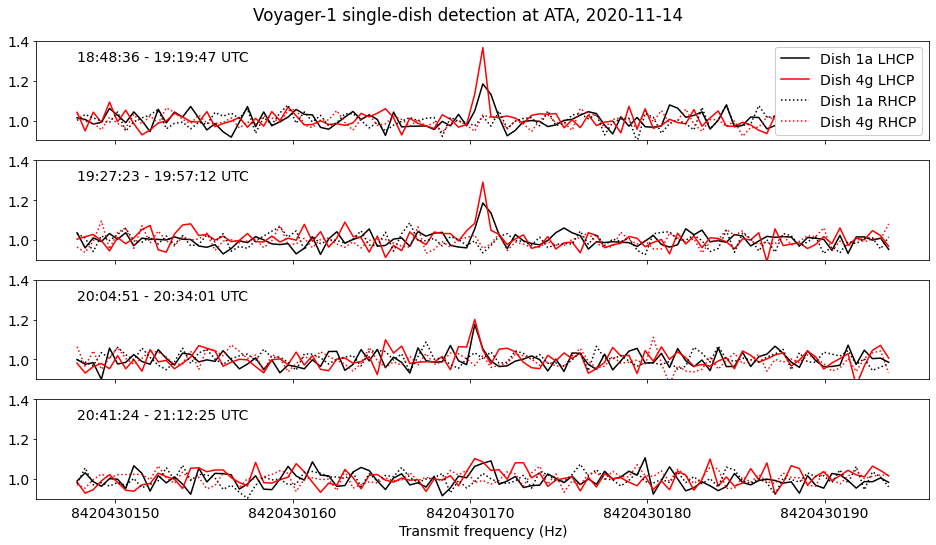

In [18]:
sel = range(peak-50,peak+51)
freqs = np.fft.fftshift(np.fft.fftfreq(Nfft, 1/fs))[sel] + spacecraft_freq
fig, ax = plt.subplots(spectra_cal.shape[0], 1,
                       figsize = (16,8), facecolor = 'w',
                       sharex = True)
for j in range(spectra_cal.shape[0]):
    ax[j].set_prop_cycle(custom_cycler)
    ax[j].plot(freqs, spectra_cal[j,:,sel]/durations[j]*np.sum(durations))
    ax[j].set_ylim((0.9,1.4))
    ax[j].text(freqs[0], 1.3,
               f"{str(timestamps[j].datetime.time()).split('.')[0]} - {str(timestamps_ends[j].datetime.time()).split('.')[0]} UTC")
    ax[j].ticklabel_format(useOffset = False, style = 'plain')
ax[0].legend(channel_labels,
            loc = 'right', framealpha = 1)
ax[-1].set_xlabel('Transmit frequency (Hz)');
plt.suptitle('Voyager-1 single-dish detection at ATA, 2020-11-14')
#plt.tight_layout();
plt.subplots_adjust(top=0.92)

Below we estimate the CN0 received in each antenna and polarization. The estimate is not very precise because the signal is rather weak.

In [19]:
sel_S = np.arange(peak-3,peak+4)
S = np.sum(spectra_cal[...,sel_S]/np.array(durations)[:,np.newaxis,np.newaxis]*np.sum(durations), axis = -1)
N = 1
S -= N * sel_S.size
SNR = S/N
CN0 = SNR/(fs/Nfft)
10*np.log10(CN0[:,:2])

array([[-1.75056913e+00,  4.03906490e-01],
       [-2.05854779e+00,  1.11586580e-01],
       [-5.79919510e+00,  2.96506089e-03],
       [-3.32042925e+00, -2.19911005e+00]])